In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Model

In [2]:
# Define the Custom CNN
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 24 * 24, 32)  # Adjust dimensions after pooling
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Increased filters
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Increased filters
        self.bn2 = nn.BatchNorm2d(32)
        
        # Convolutional Block 3 (New Layer)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # New layer
        self.bn3 = nn.BatchNorm2d(64)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 12 * 12, 64)  # Adjusted for additional conv layer
        self.dropout = nn.Dropout(0.5)  # Added dropout
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Load Data

In [28]:
# Transformations for STL-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


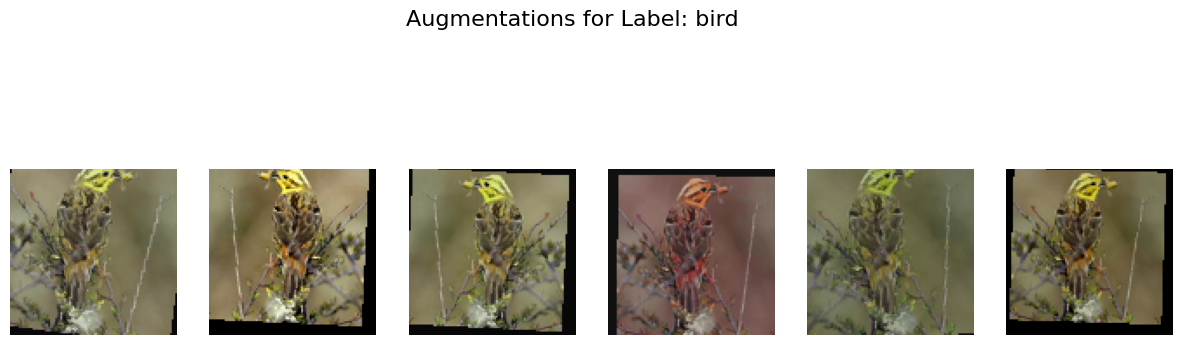

In [ ]:
from PIL import Image

# Define the augmentation pipeline without normalization
transform_train_no_norm = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load an example image from the STL-10 dataset
dataset = datasets.STL10(root='./data', split='train', download=True)
image, label = dataset[0]  # Get the first image and label
label_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Visualize augmentations
def visualize_augmentations(transform, image, n_samples=6):
    """Applies augmentations and displays them."""
    plt.figure(figsize=(15, 5))
    for i in range(n_samples):
        augmented_image = transform(image)  # Apply augmentations
        # Convert tensor back to a PIL image for visualization
        augmented_image = transforms.ToPILImage()(augmented_image)  # No need to denormalize
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(augmented_image)
        plt.axis('off')
    plt.suptitle(f'Augmentations for Label: {label_names[label]}', fontsize=16)
    plt.show()

# Call the function to visualize augmentations
visualize_augmentations(transform_train_no_norm, image)

### Train and Test

In [29]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, train_losses=[], val_losses=[]):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# Testing Loop
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

In [30]:
# Model, Loss, Optimizer
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train and Evaluate
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, train_losses=[], val_losses=[])
test_model(model, test_loader)

Epoch [1/20], Train Loss: 2.1092, Val Loss: 1.9510
Epoch [2/20], Train Loss: 1.7822, Val Loss: 1.7723
Epoch [3/20], Train Loss: 1.6537, Val Loss: 1.7710
Epoch [4/20], Train Loss: 1.5891, Val Loss: 1.5774
Epoch [5/20], Train Loss: 1.5184, Val Loss: 1.5414
Epoch [6/20], Train Loss: 1.4887, Val Loss: 1.4979
Epoch [7/20], Train Loss: 1.4373, Val Loss: 1.4686
Epoch [8/20], Train Loss: 1.4078, Val Loss: 1.4625
Epoch [9/20], Train Loss: 1.4209, Val Loss: 1.4713
Epoch [10/20], Train Loss: 1.3927, Val Loss: 1.5270
Epoch [11/20], Train Loss: 1.3748, Val Loss: 1.4114
Epoch [12/20], Train Loss: 1.3617, Val Loss: 1.3810
Epoch [13/20], Train Loss: 1.3405, Val Loss: 1.3855
Epoch [14/20], Train Loss: 1.3298, Val Loss: 1.3647
Epoch [15/20], Train Loss: 1.3184, Val Loss: 1.3589
Epoch [16/20], Train Loss: 1.2951, Val Loss: 1.3592
Epoch [17/20], Train Loss: 1.2836, Val Loss: 1.3559
Epoch [18/20], Train Loss: 1.2826, Val Loss: 1.3449
Epoch [19/20], Train Loss: 1.2579, Val Loss: 1.3398
Epoch [20/20], Train 

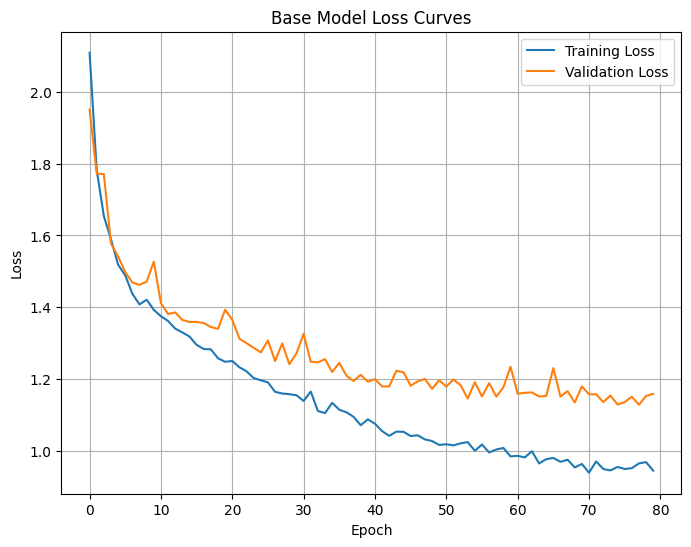

[2.10919141920307, 1.7822490945647034, 1.6537261009216309, 1.5890700183337247, 1.5184190710888634, 1.488708236549474, 1.437276988089839, 1.4077809475645233, 1.4209444221061995, 1.3927043555658074, 1.3748190267176568, 1.361662217333347, 1.340451397473299, 1.3298006208637092, 1.3183703075481366, 1.2950611642644376, 1.2836476247521895, 1.282630811009226, 1.2578894428060026, 1.2480159409438507, 1.250298801856705, 1.2327534239503402, 1.2215013994446284, 1.2027365346498127, 1.1964543982397151, 1.1906964665726771, 1.1643342081504533, 1.1596155679678615, 1.157778946659233, 1.1547330610359772, 1.138830537282968, 1.165114471429511, 1.1110146905802474, 1.1050975881045377, 1.1335752108429051, 1.1145265668253355, 1.1073073488247545, 1.0946921992905532, 1.0712615621240833, 1.087737820570982, 1.075257031977931, 1.0548981179164936, 1.0416913145705113, 1.0534118640271923, 1.0529117312612413, 1.0412193400950371, 1.043188153942929, 1.0317513842748691, 1.0271818486950066, 1.0163150037391275, 1.01830920388

In [43]:
# Function to plot the loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Base Model Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the curves
plot_loss_curves(train_losses, val_losses)
print(train_losses)
print(val_losses)


### Visualizations

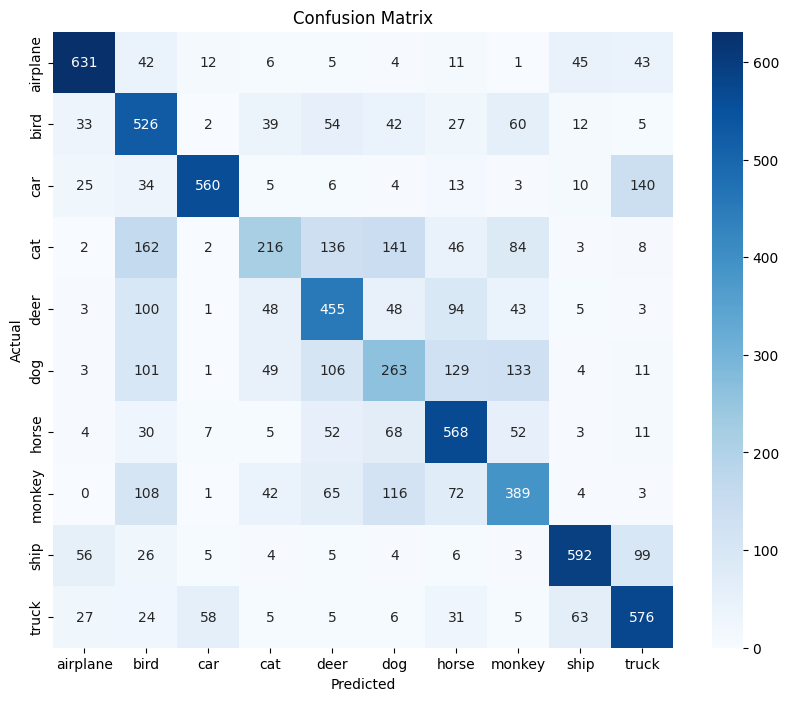

Accuracy: 0.60
Loss: 1.1562
F1 Score (Weighted): 0.59


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def evaluate_model_and_confusion_matrix(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()  # Use the same loss function as during training

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions and labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1_score = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)['weighted avg']['f1-score']

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Loss: {total_loss / len(dataloader):.4f}")
    print(f"F1 Score (Weighted): {f1_score:.2f}")

# Class names for STL-10
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Evaluate the model and create confusion matrix
evaluate_model_and_confusion_matrix(model, test_loader, classes)


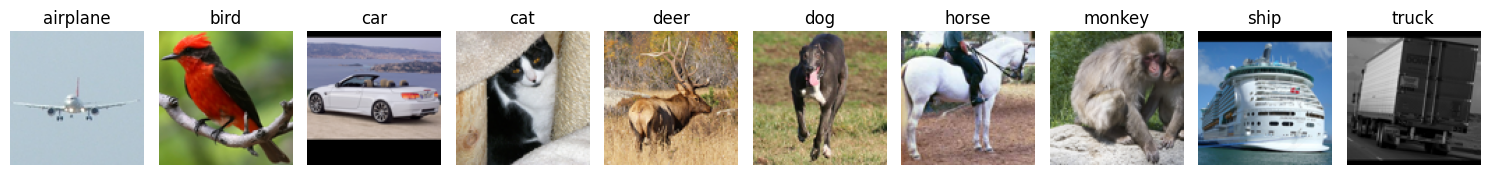

In [ ]:
# Class labels for STL-10
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Function to display a grid of images, one from each class
def show_images(dataset, classes, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    class_indices = {cls: [] for cls in range(num_images)}
    
    # Collect indices for each class
    for idx, (image, label) in enumerate(dataset):
        if label in class_indices and len(class_indices[label]) < 5:  # Collect up to 5 indices per class
            class_indices[label].append(idx)
        if all(len(indices) >= 5 for indices in class_indices.values()):  # Ensure we have enough images to choose from
            break
    
    for i, (cls, indices) in enumerate(class_indices.items()):
        # Select a random image from the collected indices
        idx = random.choice(indices)
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # De-normalize to [0, 1] range
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(classes[label])
    
    plt.tight_layout()
    plt.show()

# Plot class distribution for training and testing datasets
show_images(train_dataset, classes, num_images=10)

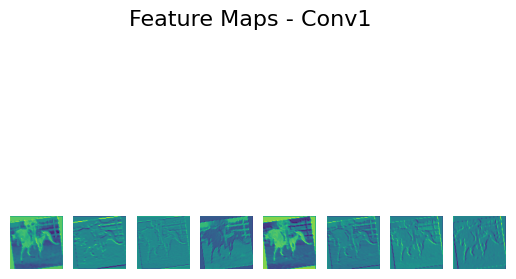

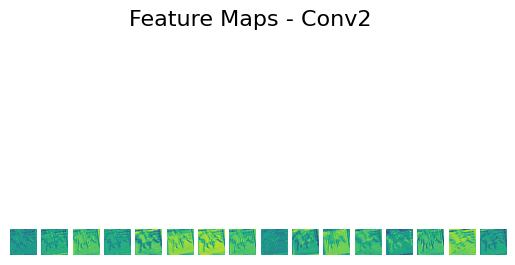

In [ ]:
# Function to visualize feature maps
def visualize_feature_maps(model, image):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Pass the image through the first convolutional layer
    with torch.no_grad():
        # Extract the feature maps from each convolutional layer
        feature_map_1 = model.conv1(image.unsqueeze(0).to(device))  # Add batch dimension
        feature_map_2 = model.conv2(model.pool(torch.relu(feature_map_1)))
    
    # Convert feature maps to CPU for visualization
    feature_map_1 = feature_map_1.cpu()
    feature_map_2 = feature_map_2.cpu()

    # Plot the feature maps from the first convolutional layer
    num_filters_1 = feature_map_1.size(1)
    for i in range(num_filters_1):
        plt.subplot(1, num_filters_1, i + 1)
        plt.imshow(feature_map_1[0, i].numpy(), cmap='viridis')  # First image in batch, i-th filter
        plt.axis('off')
    plt.suptitle('Feature Maps - Conv1', fontsize=16)
    plt.show()

    # Plot the feature maps from the second convolutional layer
    num_filters_2 = feature_map_2.size(1)
    for i in range(num_filters_2):
        plt.subplot(1, num_filters_2, i + 1)
        plt.imshow(feature_map_2[0, i].numpy(), cmap='viridis')  # First image in batch, i-th filter
        plt.axis('off')
    plt.suptitle('Feature Maps - Conv2', fontsize=16)
    plt.show()

# Load a single image from the test dataset
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Visualize the feature maps for the first image in the batch
visualize_feature_maps(model, images[0])
